In [1]:
# Gerekli kütüphanelerin içe aktarılması
import os
import random
import sys
import numpy as np
import pandas as pd
import scipy.io.wavfile as sci_wav
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    Conv1D, GlobalAveragePooling1D, MaxPooling1D
)
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Dizin yollarının tanımlanması
ROOT_DIR = "/content/drive/MyDrive/CatOrDog/cats_dogs"  # Mevcut dizin
TRAIN_CAT_DIR = os.path.join(ROOT_DIR, "train", "cat")
TRAIN_DOG_DIR = os.path.join(ROOT_DIR, "train", "dog")
TEST_CAT_DIR = os.path.join(ROOT_DIR, "test","cats")
TEST_DOG_DIR = os.path.join(ROOT_DIR, "test","dogs")

In [4]:
# Dizinlerin varlığını kontrol et
for directory in [TRAIN_CAT_DIR, TRAIN_DOG_DIR, TEST_CAT_DIR, TEST_DOG_DIR]:
    if not os.path.exists(directory):
        print(f"Uyarı: {directory} dizini bulunamadı!")
    else:
        print(f"✓ {directory} dizini mevcut")


✓ /content/drive/MyDrive/CatOrDog/cats_dogs/train/cat dizini mevcut
✓ /content/drive/MyDrive/CatOrDog/cats_dogs/train/dog dizini mevcut
✓ /content/drive/MyDrive/CatOrDog/cats_dogs/test/cats dizini mevcut
✓ /content/drive/MyDrive/CatOrDog/cats_dogs/test/dogs dizini mevcut


In [5]:

# WAV dosyalarını listeleme fonksiyonu
def get_wav_files(directory):
    """Bir dizindeki tüm WAV dosyalarını listele"""
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Dizin bulunamadı: {directory}")
    wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    print(f"{directory} içinde {len(wav_files)} WAV dosyası bulundu")
    return wav_files


In [6]:

# Test - WAV dosyalarını listele
train_cat_files = get_wav_files(TRAIN_CAT_DIR)
train_dog_files = get_wav_files(TRAIN_DOG_DIR)
test_cat_files = get_wav_files(TEST_CAT_DIR)
test_dog_files = get_wav_files(TEST_DOG_DIR)

/content/drive/MyDrive/CatOrDog/cats_dogs/train/cat içinde 125 WAV dosyası bulundu
/content/drive/MyDrive/CatOrDog/cats_dogs/train/dog içinde 85 WAV dosyası bulundu
/content/drive/MyDrive/CatOrDog/cats_dogs/test/cats içinde 39 WAV dosyası bulundu
/content/drive/MyDrive/CatOrDog/cats_dogs/test/dogs içinde 28 WAV dosyası bulundu


In [7]:
# WAV dosyalarını okuma fonksiyonu
def read_wav_files(directory, wav_files):
    """WAV dosyalarını oku ve numpy dizisine dönüştür"""
    if not isinstance(wav_files, list):
        wav_files = [wav_files]

    audio_data = []
    for f in wav_files:
        try:
            _, data = sci_wav.read(os.path.join(directory, f))
            audio_data.append(data)
        except Exception as e:
            print(f"Hata - {f} dosyası okunamadı: {str(e)}")
    return audio_data


In [8]:
# Ses dilimleme fonksiyonu
def get_trunk(_X, idx, sample_len, rand_offset=False):
    """Ses verisinden belirli uzunlukta bir dilim al"""
    randint = np.random.randint(10000) if rand_offset else 0
    start_idx = (idx * sample_len + randint) % len(_X)
    end_idx = ((idx + 1) * sample_len + randint) % len(_X)
    if end_idx > start_idx:
        return _X[start_idx:end_idx]
    else:
        return np.concatenate((_X[start_idx:], _X[:end_idx]))

In [9]:
# Veri artırma fonksiyonu
def get_augmented_trunk(_X, idx, sample_len, added_samples=0):
    """Ses verisini artır ve karıştır"""
    X = get_trunk(_X, idx, sample_len)
    for _ in range(added_samples):
        ridx = np.random.randint(len(_X))
        X = X + get_trunk(_X, ridx, sample_len)
    return X

In [10]:
# Veri seti oluşturma fonksiyonu
def dataset_gen(dataset, is_train=True, batch_shape=(20, 16000), sample_augmentation=0):
    """Eğitim için batch veri üret"""
    s_per_batch, s_len = batch_shape
    X_cat = dataset["train_cat"] if is_train else dataset["test_cat"]
    X_dog = dataset["train_dog"] if is_train else dataset["test_dog"]

    y_batch = np.zeros(s_per_batch)
    X_batch = np.zeros(batch_shape)

    nbatch = max(len(X_cat), len(X_dog)) // s_len
    perms = [list(enumerate([i] * nbatch)) for i in range(2)]
    perms = sum(perms, [])
    random.shuffle(perms)

    while len(perms) >= s_per_batch:
        for bidx in range(s_per_batch):
            perm, y = perms.pop()
            y_batch[bidx] = y
            X = X_cat if y == 0 else X_dog
            if is_train:
                X_batch[bidx] = get_augmented_trunk(X, perm, s_len, sample_augmentation)
            else:
                X_batch[bidx] = get_trunk(X, perm, s_len)
        yield X_batch.reshape(s_per_batch, s_len, 1), y_batch.reshape(-1, 1)

In [11]:
# Veri setini yükleme fonksiyonu
def load_dataset():
    """Tüm ses verilerini yükle ve işle"""
    dataset = {}

    data_pairs = [
        ('train_cat', TRAIN_CAT_DIR, train_cat_files),
        ('train_dog', TRAIN_DOG_DIR, train_dog_files),
        ('test_cat', TEST_CAT_DIR, test_cat_files),
        ('test_dog', TEST_DOG_DIR, test_dog_files)
    ]

    for key, directory, files in data_pairs:
        try:
            print(f"\n{key} verisi yükleniyor...")
            v = read_wav_files(directory, files)
            v = np.concatenate(v).astype('float32')
            mean, std = v.mean(), v.std()
            v = (v - mean) / std
            dataset[key] = v
            print(f"✓ {key}: {len(v) / 16000:.2f} saniye ses yüklendi")
        except Exception as e:
            print(f"✗ {key} yüklenirken hata: {str(e)}")

    return dataset

In [12]:
# Veri setini yükle
print("Veri seti yükleniyor...")
dataset = load_dataset()

Veri seti yükleniyor...

train_cat verisi yükleniyor...
✓ train_cat: 1040.49 saniye ses yüklendi

train_dog verisi yükleniyor...
✓ train_dog: 471.76 saniye ses yüklendi

test_cat verisi yükleniyor...
✓ test_cat: 283.41 saniye ses yüklendi

test_dog verisi yükleniyor...
✓ test_dog: 126.68 saniye ses yüklendi


In [13]:
# Model parametreleri
batch_size = 512
num_data_points = 16000
n_augment = 10
NUM_EPOCHS = 50

In [14]:
# Model oluşturma
print("\nModel oluşturuluyor...")
K.clear_session()
model = Sequential([
    Conv1D(20, 4, strides=2, activation='relu', input_shape=(num_data_points, 1)),
    BatchNormalization(),
    Conv1D(20, 4, strides=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(40, 4, strides=2, activation='relu'),
    BatchNormalization(),
    Conv1D(40, 4, strides=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(80, 4, strides=2, activation='relu'),
    BatchNormalization(),
    Conv1D(80, 4, strides=2, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



Model oluşturuluyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Model özeti
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7999, 20)            │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7999, 20)            │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3998, 20)            │           1,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3998, 20)            │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1999, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 998, 40)             │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 998, 40)             │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 498, 40)             │           6,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 498, 40)             │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 249, 40)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 123, 80)             │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 123, 80)             │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 60, 80)              │          25,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 60, 80)              │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 80)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,913 (546.54 KB)

 Trainable params: 138,329 (540.35 KB)

 Non-trainable params: 1,584 (6.19 KB)

In [16]:
# Model derleme
print("\nModel derleniyor...")
adam_optimizer = Adam(decay=1e-3)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy']
)


Model derleniyor...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [17]:
# Eğitim tarihçesi için listeler
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [18]:
# Model eğitimi
print("\nModel eğitimi başlıyor...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_gen = dataset_gen(
        dataset,
        is_train=True,
        batch_shape=(batch_size, num_data_points),
        sample_augmentation=n_augment
    )

    for batch_x, batch_y in train_gen:
        history = model.fit(
            batch_x,
            batch_y,
            epochs=1,
            validation_split=0.2,
            verbose=1
        )
        train_loss.extend(history.history['loss'])
        val_loss.extend(history.history['val_loss'])
        train_acc.extend(history.history['accuracy'])
        val_acc.extend(history.history['val_accuracy'])


Model eğitimi başlıyor...

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 425ms/step - accuracy: 0.6786 - loss: 0.6441 - val_accuracy: 0.5631 - val_loss: 0.6793
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.9014 - loss: 0.2364 - val_accuracy: 0.4660 - val_loss: 0.6706
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.9400 - loss: 0.2277 - val_accuracy: 0.5146 - val_loss: 0.6634
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step - accuracy: 0.9255 - loss: 0.2231 - val_accuracy: 0.4660 - val_loss: 0.6751

Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.9451 - loss: 0.1481 - val_accuracy: 0.4757 - val_loss: 0.6692
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9628 - loss: 0.1017 - val_accuracy: 0.5049 - val_loss: 0.6178
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step - accuracy: 0.9704 - loss: 0.0735 - val_accuracy: 0.5146 - val_loss: 0.5994
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.9662 - loss: 0.1034 - val_accuracy: 0.4563 - val_loss: 0.7805

Epoch 3/50


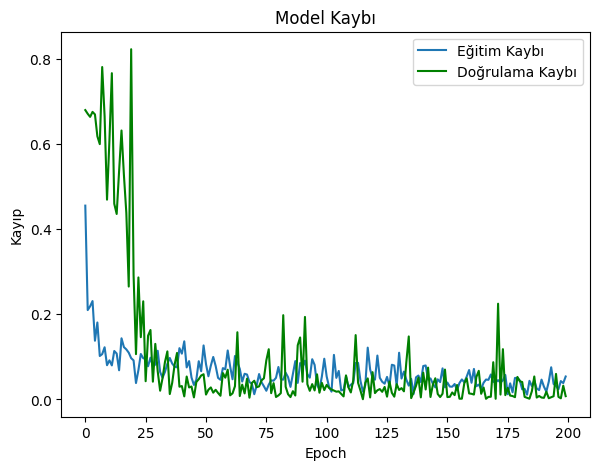

In [19]:
# Eğitim performansını görselleştirme
plt.figure(figsize=(15, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı', color='green')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

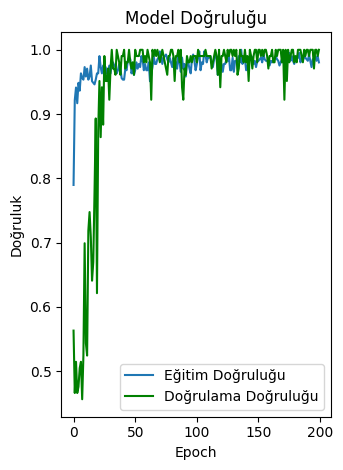

In [20]:
# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu', color='green')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Model kaydetme
print("\nModel kaydediliyor...")
model.save('cat_dog_audio_classifier.h5')
print("✓ Model başarıyla kaydedildi: 'cat_dog_audio_classifier.h5'")


Model kaydediliyor...
✓ Model başarıyla kaydedildi: 'cat_dog_audio_classifier.h5'


In [22]:
# Eğitim sonuçlarını yazdır
print("\nEğitim Sonuçları:")
print(f"Son eğitim kaybı: {train_loss[-1]:.4f}")
print(f"Son doğrulama kaybı: {val_loss[-1]:.4f}")
print(f"Son eğitim doğruluğu: {train_acc[-1]:.4f}")
print(f"Son doğrulama doğruluğu: {val_acc[-1]:.4f}")


Eğitim Sonuçları:
Son eğitim kaybı: 0.0538
Son doğrulama kaybı: 0.0077
Son eğitim doğruluğu: 0.9804
Son doğrulama doğruluğu: 1.0000
